In [72]:
# review SEG ML contest

In [118]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.neural_network import MLPRegressor
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
import seaborn as sns
from sklearn import preprocessing
from sklearn.svm import SVC,SVR
from sklearn.model_selection import train_test_split

In [2]:
from ukpgks import plots

## Shortly about contest
### Classification problem

features: five logs, two indicators. PE  log missed for some wells

labels   : facies, nine types - multiclass classification

training datasets: nine wells

Approach 1
Convert Well Name and Formation to category type
Hold one well as test data
Have a look at data, plot facies with thier color
Standart scaler features
cross validation train_test_split 0.1 st 42
SVM


In [122]:
# read datasets: train and test
df= pd.read_csv('facies_vectors.csv')
features  = ['GR','ILD_log10','DeltaPHI','PHIND','PE','NM_M','RELPOS']
well_logs = ['GR','ILD_log10','DeltaPHI','PHIND','PE']
data = df.copy()
data = df[df['Well Name']!='Recruit F9'] # psedo well remove
print (data.shape,f"Number of wells {df['Well Name'].unique().size}")

(4069, 11) Number of wells 10


In [123]:
# understanding of targets 
labels_descriptions = pd.read_csv('labels.csv',
                                  header=0,index_col=None,sep=';')
facies_description = dict()
for v,k in zip(labels_descriptions['Description '],labels_descriptions['Facies ']):
    facies_description[k] = v
wellnames = df['Well Name'].unique()
labels_descriptions.head(10)

,Facies,Description,Label,Adjacent Facies
0,1,Nonmarine Sandstone,SS,2
1,2,Nonmarine coarse siltstone,CSiS,1.3
2,3,Nonmarine fine siltstone,FSiS,2
3,4,Marine siltstone and shale,SiSh,5
4,5,Mudstone,MS,4.6
5,6,Wackestone,WS,5.7.8
6,7,Dolomite,D,6.8
7,8,Packstone-grainstone,PS,6.7.9
8,9,Phylloid-algal bafflestone,BS,7.8


In [176]:
facies_colors = ['#F4D03F', '#F5B041','#DC7633','#6E2C00','#1B4F72','#2E86C1', '#AED6F1', '#A569BD', '#196F3D']
facies_names  = ['SS', 'CSiS', 'FSiS', 'SiSh', 'MS','WS', 'D','PS', 'BS']
faceis_labels = [] 
for i in range(len(facies_names)):
    faceis_labels.append(str(i)+str('-')+facies_names[i])
faceis_labels

['0-SS', '1-CSiS', '2-FSiS', '3-SiSh', '4-MS', '5-WS', '6-D', '7-PS', '8-BS']

In [124]:
# map facies with their colors: 'SS': '#F4D03F'
facies_color_map = {} 
facies_label_map = {}

for ind, label in enumerate(facies_names):
    facies_color_map[ind+1] = facies_colors[ind]
    facies_label_map[ind+1] = facies_names[ind]
# create consistent color maping for all facies and abbreviated facies labels
data.loc[:,'FaciesColors'] = data.loc[:,'Facies'].map(facies_color_map)
data.loc[:,'FaciesLabels'] = data.loc[:,'Facies'].map(facies_label_map)
data.loc[:,'FaciesDescrip'] = data.loc[:,'Facies'].map(facies_description)

data.head(3)

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


,Facies,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS,FaciesColors,FaciesLabels,FaciesDescrip
0,3,A1 SH,SHRIMPLIN,2793.0,77.45,0.664,9.9,11.915,4.6,1,1.000,#DC7633,FSiS,Nonmarine fine siltstone
1,3,A1 SH,SHRIMPLIN,2793.5,78.26,0.661,14.2,12.565,4.1,1,0.979,#DC7633,FSiS,Nonmarine fine siltstone
2,3,A1 SH,SHRIMPLIN,2794.0,79.05,0.658,14.8,13.050,3.6,1,0.957,#DC7633,FSiS,Nonmarine fine siltstone


In [125]:
data['Well Name'] = data['Well Name'].astype('category')
data['Formation'] = data['Formation'].astype('category')
print (data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4069 entries, 0 to 4148
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Facies         4069 non-null   int64   
 1   Formation      4069 non-null   category
 2   Well Name      4069 non-null   category
 3   Depth          4069 non-null   float64 
 4   GR             4069 non-null   float64 
 5   ILD_log10      4069 non-null   float64 
 6   DeltaPHI       4069 non-null   float64 
 7   PHIND          4069 non-null   float64 
 8   PE             3164 non-null   float64 
 9   NM_M           4069 non-null   int64   
 10  RELPOS         4069 non-null   float64 
 11  FaciesColors   4069 non-null   object  
 12  FaciesLabels   4069 non-null   object  
 13  FaciesDescrip  4069 non-null   object  
dtypes: category(2), float64(7), int64(2), object(3)
memory usage: 422.2+ KB
None


/var/folders/xc/cnszhbxs6hn4qsj_h5yt3k7c0000gn/T/ipykernel_74130/4164799529.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Well Name'] = data['Well Name'].astype('category')
/var/folders/xc/cnszhbxs6hn4qsj_h5yt3k7c0000gn/T/ipykernel_74130/4164799529.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Formation'] = data['Formation'].astype('category')


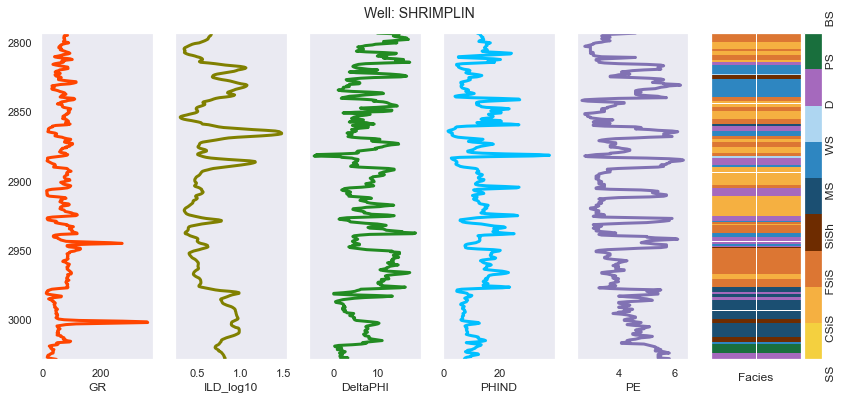

In [126]:
logs = data[data['Well Name'] == 'SHRIMPLIN']
plots.plot_logs(logs,facies_colors)

Nan values in logs:{'PE': 77.75866306217743}


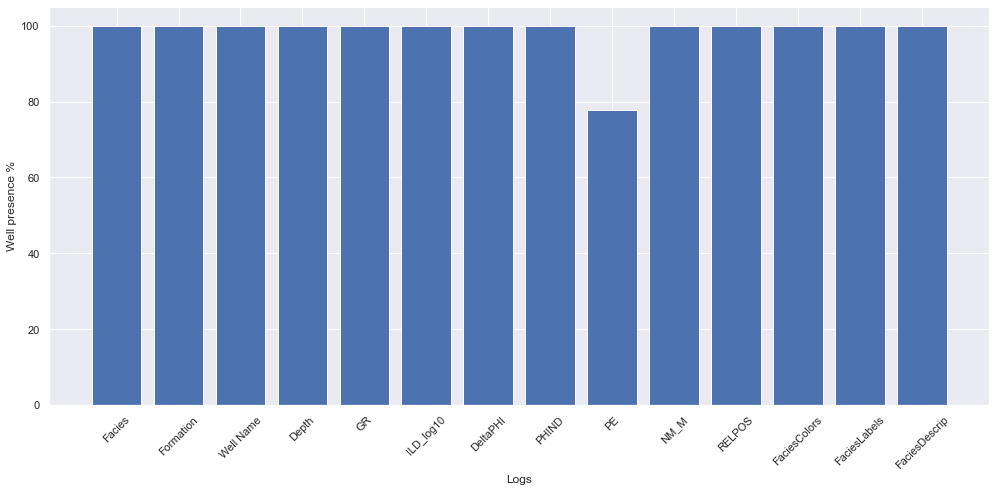

In [127]:
# exploratory data analysis
# find nan values, sum along columns, devide N_obs
train_logs = dict(100-data.isna().sum() /
                 data.shape[0] * 100)
logs_w_nan = {log:value for log,value in train_logs.items() if value!=100}
print (f'Nan values in logs:{logs_w_nan}')
# occurences of logs in wells
plt.figure(figsize=(14,7))
plt.bar(train_logs.keys(),train_logs.values())
plt.xticks(list(train_logs.keys()),rotation=45)
plt.xlabel('Logs');plt.ylabel('Well presence %');plt.tight_layout()

Text(0.5, 0, 'Facies')

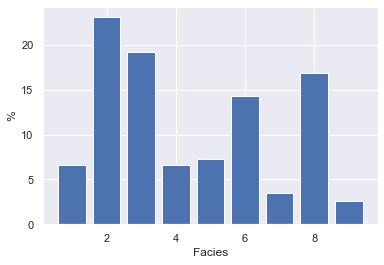

In [128]:
l = data.Facies.value_counts()
l =  (dict(sorted(l.items())))
l_perc  = np.array(list(l.values()))/data.shape[0] * 100
l_names = l.keys()
# fig = plt.figure(figsize=(15,10))
plt.bar(l_names,l_perc); plt.ylabel('%');plt.xlabel('Facies')

<AxesSubplot:title={'center':'Distribution of Training Data by Facies'}>

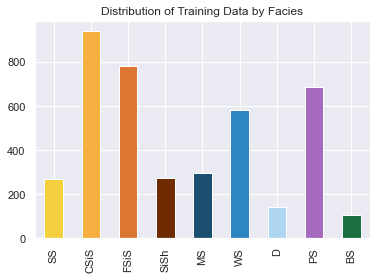

In [129]:
facies_counts = data['Facies'].value_counts().sort_index()
facies_counts.index = facies_label_map.values()
facies_counts.plot(kind='bar',color=facies_colors, 
                   title='Distribution of Training Data by Facies')

In [130]:
# plot hist for logs
# facies shpuld have diff properties to classify them or separate from each other
# data.DeltaPHI.hist(bins=50,by=data['FaciesDescrip'],color='k',
#                           figsize=(15,6), layout=(3,3),lw=0)
# plt.tight_layout()

# train test split
data = data_all.copy()
data = data[~data['PE'].isna()]
valid  = data[data['Well Name']=='SHANKLE']
train = data[data['Well Name']!='SHANKLE']
print (test.shape,data.shape)

(449, 14) (3164, 14)


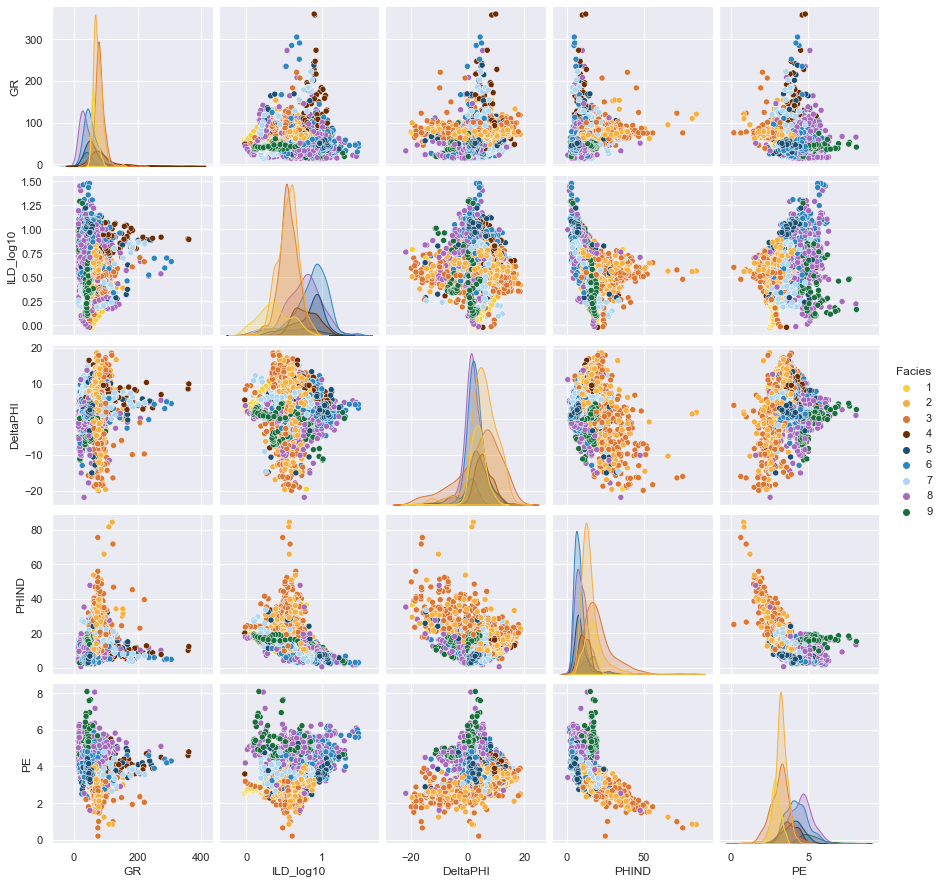

In [131]:
#save plot display settings to change back to when done plotting with seaborn
sns.pairplot(data.loc[:,['GR','ILD_log10','DeltaPHI','PHIND','PE','Facies']],
                      palette=facies_color_map,hue='Facies')

In [142]:
feature_v = train[features]
sc = preprocessing.StandardScaler()
sc.fit(feature_v)
a = sc.transform(feature_v)
train.loc[:,features] = a

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1835: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


In [145]:
X_train,X_test,y_train,y_test = train_test_split(train[features],
                                                train['Facies'].values,
                                                random_state=42)

In [146]:
classifier = SVC()
classifier.fit(X_train,y_train)
y_precid = classifier.predict(X_test)

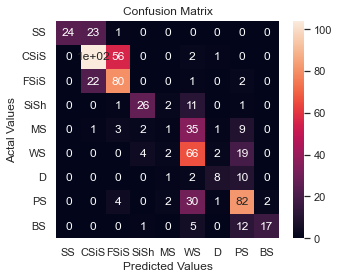

In [164]:
# classifier.score(X_test,y_test)
# cm = confusion_matrix(y_test,y_precid)
cm_df = pd.DataFrame(cm,index=facies_names,columns=facies_names)
plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

In [171]:
np.unique(y_test)
y_test[y_test==1].sum()

48

In [153]:
def accuracy(conf):
    total_correct = 0.
    nb_classes = conf.shape[0]
    for i in np.arange(0,nb_classes):
        total_correct += conf[i][i]
    acc = total_correct/sum(sum(conf))
    return acc

adjacent_facies = np.array([[1], [0,2], [1], [4], [3,5], [4,6,7], [5,7], [5,6,8], [6,7]])

def accuracy_adjacent(conf, adjacent_facies):
    nb_classes = conf.shape[0]
    total_correct = 0.
    for i in np.arange(0,nb_classes):
        total_correct += conf[i][i]
        for j in adjacent_facies[i]:
            total_correct += conf[i][j]
    return total_correct / sum(sum(conf))


/var/folders/xc/cnszhbxs6hn4qsj_h5yt3k7c0000gn/T/ipykernel_74130/3633271549.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  adjacent_facies = np.array([[1], [0,2], [1], [4], [3,5], [4,6,7], [5,7], [5,6,8], [6,7]])


array([list([1]), list([0, 2]), list([1]), list([4]), list([3, 5]),
       list([4, 6, 7]), list([5, 7]), list([5, 6, 8]), list([6, 7])],
      dtype=object)

In [154]:
print('Facies classification accuracy = %f' % accuracy(cm))
print('Adjacent facies classification accuracy = %f' % accuracy_adjacent(cm, adjacent_facies))

Facies classification accuracy = 0.600884
Adjacent facies classification accuracy = 0.924890
